In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
import keras
# from tensorflow.python.keras import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Lambda
# from tensorflow.python.keras. import BatchNormalization
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import (Input, Conv2D, Conv2DTranspose, MaxPooling2D, SeparableConv2D,UpSampling2D, Activation, add)
# from tensorflow.keras.layers.normalization import BatchNormalizatio
# from tensorflow.python.keras.
from tensorflow.keras.regularizers import l2
import os
from sklearn.model_selection import train_test_split
import numpy as np           
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
from IPython.display import display
from IPython.display import FileLink
from PIL import Image

In [3]:
base_path = 'garbage-dataset'
IMG_SIZE = (224,224)
BATCH_SIZE = 16

In [4]:
def prep_image(file_path, label):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = img / 255.0
    return img, label

In [5]:
def get_dataset_path(base_path):
    classes = sorted(os.listdir(base_path))
    file_paths = []
    labels = []

    for i, class_name in enumerate(classes):
        class_dir = os.path.join(base_path, class_name)
        for file_name in os.listdir(class_dir):
            file_path = os.path.join(class_dir, file_name)
            img = Image.open(file_path)
            if img.format in ['JPEG', 'JPG', 'PNG', 'GIF', 'BMP']:
                file_paths.append(file_path)
                labels.append(i) # Label with integer

    return file_paths, labels, classes

In [6]:
def get_dataset_path(base_path):
    classes = sorted(os.listdir(base_path))
    file_paths = []
    labels = []

    for i, class_name in enumerate(classes):
        class_dir = os.path.join(base_path, class_name)
        for file_name in os.listdir(class_dir):
            file_path = os.path.join(class_dir, file_name)
            img = Image.open(file_path)
            if img.format in ['JPEG', 'JPG', 'PNG', 'GIF', 'BMP']:
                file_paths.append(file_path)
                labels.append(i) # Label with integer

    return file_paths, labels, classes

In [8]:
file_paths, labels, class_names = get_dataset_path(base_path)

print(f"Found {len(file_paths)} images in {len(class_names)} classes.")

Found 19753 images in 10 classes.


In [9]:
train_paths, test_paths, train_labels, test_labels = train_test_split(
    file_paths, labels, test_size=0.2, random_state=42
)
val_paths, test_paths, val_labels, test_labels = train_test_split(
    test_paths, test_labels, test_size=0.5, random_state=42
)

In [10]:
def create_dataset(file_paths, labels):
    dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))
    dataset = dataset.map(prep_image, num_parallel_calls = tf.data.AUTOTUNE)
    dataset = dataset.shuffle(buffer_size = 1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    
    return dataset

In [11]:
train_dataset = create_dataset(train_paths, train_labels)
test_dataset = create_dataset(test_paths, test_labels)
val_dataset = create_dataset(val_paths, val_labels)

Image shape: (16, 224, 224, 3)
Label: [6 2 9 3 1 3 1 3 7 8 6 3 2 4 3 7]


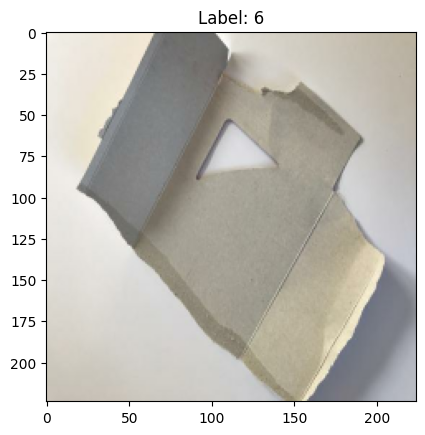

In [10]:
for image, label in train_dataset.take(1):
        print("Image shape:", image.shape)
        print("Label:", label.numpy())
        plt.imshow(image[0].numpy())
        plt.title(f"Label: {label.numpy()[0]}")
        plt.show

In [11]:
def augment_image(img, label):
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_flip_up_down(img)
    img = tf.image.random_brightness(img, max_delta=0.2)
    img = tf.image.random_contrast(img, lower=0.8, upper=1.2)
    img = tf.image.random_saturation(img, lower=0.8, upper=1.2)
    img = tf.image.random_hue(img, max_delta=0.1)
    img = tf.image.resize(img, IMG_SIZE)
    return img, label

train_dataset = train_dataset.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)

In [12]:
def build_model(num_classes):
    base_model = keras.applications.MobileNetV2(include_top=False, weights='imagenet', input_shape=IMG_SIZE + (3,))
    
    for layer in base_model.layers[-70:]:
        layer.trainable = True
        
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        # Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
        # Lambda(lambda x: x * 1.0),
        Dense(128, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        Dropout(0.5),  
        Dense(num_classes, activation='softmax')  
    ])
    
    return model

In [13]:
tf.keras.backend.clear_session()

num_classes = len(class_names)
model = build_model(num_classes)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                        

In [14]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr= 1e-6)

In [15]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),  
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [16]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights = dict(enumerate(class_weights))

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,  
    class_weight=class_weights,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/10
988/988 [==============================] - 186s 181ms/step - loss: 2.1466 - accuracy: 0.3632 - val_loss: 0.9445 - val_accuracy: 0.7119 - lr: 1.0000e-05
Epoch 2/10
988/988 [==============================] - 182s 183ms/step - loss: 1.1359 - accuracy: 0.6407 - val_loss: 0.5997 - val_accuracy: 0.8273 - lr: 1.0000e-05
Epoch 3/10
988/988 [==============================] - 185s 185ms/step - loss: 0.8585 - accuracy: 0.7356 - val_loss: 0.4591 - val_accuracy: 0.8658 - lr: 1.0000e-05
Epoch 4/10
988/988 [==============================] - 177s 178ms/step - loss: 0.7229 - accuracy: 0.7769 - val_loss: 0.3893 - val_accuracy: 0.8800 - lr: 1.0000e-05
Epoch 5/10
988/988 [==============================] - 179s 181ms/step - loss: 0.6131 - accuracy: 0.8115 - val_loss: 0.3512 - val_accuracy: 0.8911 - lr: 1.0000e-05
Epoch 6/10
988/988 [==============================] - 183s 184ms/step - loss: 0.5658 - accuracy: 0.8259 - val_loss: 0.3163 - val_accuracy: 0.9043 - lr: 1.0000e-05
Epoch 7/10
988/988 [==

In [14]:
model = tf.keras.models.load_model('model_fixed.h5')
test_loss, test_accuracy = model.evaluate(train_dataset)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

988/988 [==============================] - 42s 41ms/step - loss: 0.1665 - accuracy: 0.9534
Test Accuracy: 95.34%


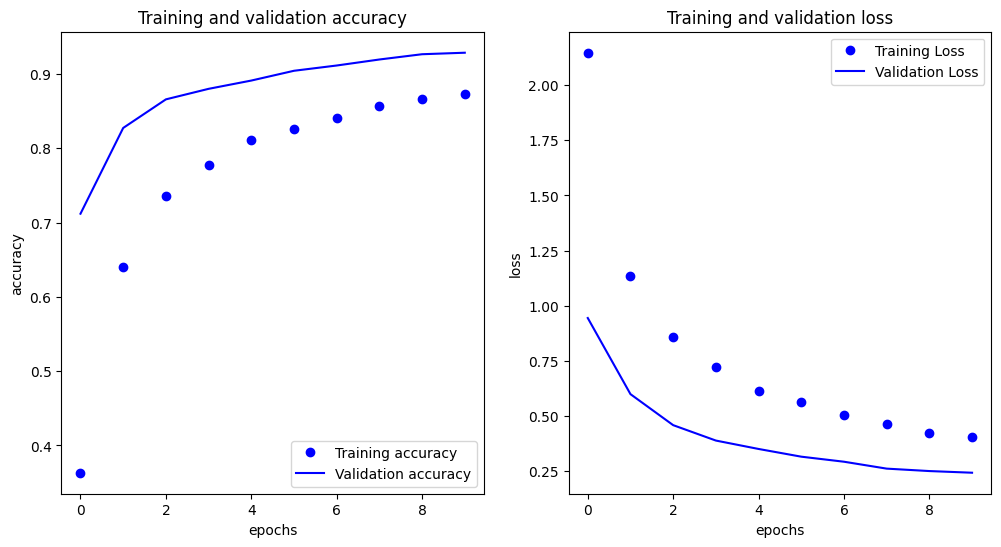

In [18]:
def plot_loss_acc(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(len(acc))
    
    fig, ax = plt.subplots(1,2, figsize=(12, 6))
    ax[0].plot(epochs, acc, 'bo', label='Training accuracy')
    ax[0].plot(epochs, val_acc, 'b', label='Validation accuracy')
    ax[0].set_title('Training and validation accuracy')
    ax[0].set_xlabel('epochs')
    ax[0].set_ylabel('accuracy')
    ax[0].legend()
    
    ax[1].plot(epochs, loss, 'bo', label='Training Loss')
    ax[1].plot(epochs, val_loss, 'b', label='Validation Loss')
    ax[1].set_title('Training and validation loss')
    ax[1].set_xlabel('epochs')
    ax[1].set_ylabel('loss')
    ax[1].legend()
    
    plt.show()

plot_loss_acc(history)

In [19]:
file_path = "/best/model_fixed.h5"
display(FileLink(file_path))

c:\best\model_fixed.h5

In [23]:
model.save('model_fixed.h5')

In [21]:
# tf.saved_model.save(model, '/kaggle/working/tf_model')